## Setup

In [1]:
import deeptrack as DT
import imageGeneration as IG
import benchmark
import unet
import cv2
import numpy as np

In [2]:
#bugfix for fredrik REMOVE LATER
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Generate images using our method

In [3]:
import os
import glob

def get_image_parameters_preconfig(image_size=256):
    from numpy.random import uniform, randint
    from numpy import ones
    from math import pi
    
    particle_number = randint(2,5)
    particle_radius_list = uniform(1,3, particle_number)
    (particle_center_x_list, particle_center_y_list) = IG.generate_particle_positions(particle_radius_list, image_size)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([1, ])
        particle_intensities_list.append([uniform(0.3, 0.5, 1), ])

    image_parameters = IG.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(.2, .5),
        signal_to_noise_ratio=lambda: uniform(3,6),
        gradient_intensity=lambda: uniform(0, 0.1),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters


get_image_parameters_function=lambda: get_image_parameters_preconfig(image_size = 51)

number_of_images_to_save = 50
batch_images,batch_labels,batch_predictions, particle_positions_and_radiuses = IG.get_batch(get_image_parameters_function = get_image_parameters_function,
                                                                                            batch_size=number_of_images_to_save,
                                                                                            include_particle_positions_radii_and_intensities = True) 



files = glob.glob('./images/*')
for f in files:
    os.remove(f)
        
for image_number,image in enumerate(batch_images):
    if image_number>=number_of_images_to_save:
        break
    
    filepath = './images/frame{}.jpg'.format(str(image_number))
    image = image*255
    cv2.imwrite(filepath,image)

cv2.destroyAllWindows()

Time taken for batch generation of size 50: 0.14364027976989746 s.


### Construct video from images


In [4]:
benchmark.construct_video_from_images(number_of_images_to_save)

In [10]:
saved_network_file_name = "DeepTrack - Example 3 - Pretrained network.h5"
dt_model = DT.load(saved_network_file_name)

video = cv2.VideoCapture("output.mp4")
(number_frames_to_be_tracked, frames, predicted_positions_wrt_frame, predicted_positions_wrt_box, 
 boxes_all) = DT.track_video("output.mp4", dt_model,box_half_size = 10,box_scanning_step = 2,frame_normalize = 0,frame_enhance = 1,number_frames_to_be_tracked = 0)


In [6]:
import time

image_size_x = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
image_size_y = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))


lower_weight = 1
higher_weight = 30

FPR_weight = 15

t = time.time()
params = benchmark.get_optimal_parameters_DT(predicted_positions_wrt_frame,
                                particle_positions_and_radiuses,
                                image_size_x, image_size_y,
                                sample_size=100,
                                x0=[12,5],
                                verbose = True,
                                number_of_iterations = 2)

t2 = time.time()-t
print(params)
print("time taken: {} sec".format(t2))

On iteration: 0, Current_guess: [4.29513016 8.01138616] , func_value: 0.7096998576379453
On iteration: 1, Current_guess: [4.29513016 8.01138616] , func_value: 0.7096998576379453
On iteration: 2, Current_guess: [4.29513016 8.01138616] , func_value: 0.7096998576379453
[4.29513016 8.01138616]
time taken: 58.61983776092529 sec


In [24]:
def get_approximate_FPR_DT(particle_positions_and_radiuses, predicted_positions_wrt_frame,image_size_x, image_size_y, lower_weight, higher_weight, sample_size= 10):
    from numpy import argmin,zeros
    weights = range(lower_weight,higher_weight,1)
    dists = zeros(len(weights))

    for w in weights:
        temp = distance_upper_left_corner_ROC_predictions_and_label_DT([9999999,0.01], particle_positions_and_radiuses,
                                                                         predicted_positions_wrt_frame,
                                                                         sample_size,image_size_x,
                                                                         image_size_y,w)
        dists[w-1] = abs(1-temp)
        print("FPR_weight : {}".format(w))
        print("dist: {}".format(abs(1-temp)))

    approximate_FPR = argmin(dists)+1
    return approximate_FPR

In [22]:
def distance_upper_left_corner_ROC_predictions_and_label_DT(params, label, pred, sample_size,image_size_x, image_size_y,FPR_weight):
        
        sample_size = min([sample_size, pred.shape[0]])
        
        predicted_positions_DT = []
        predicted_positions_DT = benchmark.get_predicted_positions_DT(params[0],
                                                               params[1],
                                                               sample_size,
                                                               pred)
        
        scanning_box_size_x = image_size_x / 12
        scanning_box_size_y = image_size_y / 12
        scanning_box_step_x = scanning_box_size_x / 20
        scanning_box_step_y = scanning_box_size_y / 20
        
        operating_characteristics = (0,0,0,0,0,0)
        operating_characteristics = benchmark.get_op_chars(predicted_positions_DT,
                                                 label,
                                                 image_size_x, image_size_y,
                                                 scanning_box_size_x, scanning_box_size_y,
                                                 scanning_box_step_x, scanning_box_step_y)
        
        
        
        
        dist = benchmark.distance_from_upper_left_corner_ROC(operating_characteristics, FPR_weight=FPR_weight)
              
        return dist

In [26]:
image_size_x = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
image_size_y = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

lower_weight = 1
higher_weight = 30

FPR_weight = get_approximate_FPR_DT(particle_positions_and_radiuses,
                                    predicted_positions_wrt_frame,image_size_x,
                                    image_size_y,
                                    lower_weight, higher_weight,
                                    sample_size= 10)

print(FPR_weight)

FPR_weight : 1
dist: 0.08502597274524737
FPR_weight : 2
dist: 0.12041590382856215
FPR_weight : 3
dist: 0.3972314324718347
FPR_weight : 4
dist: 0.7111250993298954
FPR_weight : 5
dist: 1.0450946400008783
FPR_weight : 6
dist: 1.3907414370646674
FPR_weight : 7
dist: 1.743655718666222
FPR_weight : 8
dist: 2.101357499156753
FPR_weight : 9
dist: 2.462363285953096
FPR_weight : 10
dist: 2.825737871521014
FPR_weight : 11
dist: 3.1908651315209946
FPR_weight : 12
dist: 3.5573238189688663
FPR_weight : 13
dist: 3.9248167257896585
FPR_weight : 14
dist: 4.293128444089403
FPR_weight : 15
dist: 4.662099188461218
FPR_weight : 16
dist: 5.031608016578346
FPR_weight : 17
dist: 5.401561751843473
FPR_weight : 18
dist: 5.771887477728239
FPR_weight : 19
dist: 6.1425273335629536
FPR_weight : 20
dist: 6.513434831134786
FPR_weight : 21
dist: 6.884572199178535
FPR_weight : 22
dist: 7.255908436855558
FPR_weight : 23
dist: 7.627417865315248
FPR_weight : 24
dist: 7.9990790350520165
FPR_weight : 25
dist: 8.370873891308

## Testing opt function for unet


In [5]:
import time

video = cv2.VideoCapture("output.mp4")
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

batch_images = np.zeros((number_of_images_to_save,video_height,video_width,1))


for i in range(number_of_images_to_save):
    (ret, frame) = video.read()
    batch_images[i,:,:,0] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255

model = unet.create_unet(pretrained_weights = "unet_particle.hdf5")
batch_predictions_unet = unet.predict(model,batch_images)


image_size_x = video_width
image_size_y = video_height
sample_size = 10
lower_weight = 1
higher_weight = 30

FPR_weight = benchmark.get_approximate_FPR(particle_positions_and_radiuses,
                                 batch_predictions_unet,image_size_x,
                                 image_size_y, lower_weight,higher_weight,sample_size)

print(FPR_weight)

t = time.time()
params = benchmark.get_optimal_parameters_unet(batch_predictions_unet,
                                particle_positions_and_radiuses,
                                image_size_x, image_size_y,
                                sample_size=sample_size,
                                x0=0.9,
                                verbose = True,
                                number_of_iterations = 2,
                                FPR_weight = FPR_weight)

t2 = time.time()-t
print(params)
print("time taken: {} sec".format(t2))

Using TensorFlow backend.


19
On iteration: 0, Current_guess: [0.9478125] , func_value: 0.8631226975950472
On iteration: 1, Current_guess: [0.9478125] , func_value: 0.8631226975950472
On iteration: 2, Current_guess: [0.9478125] , func_value: 0.8631226975950472
[0.9478125]
time taken: 47.077818155288696 sec


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


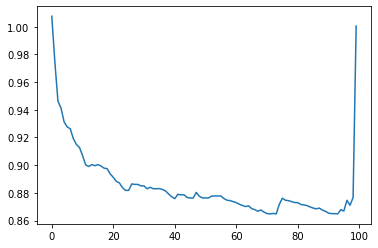

In [6]:


video = cv2.VideoCapture("output.mp4")
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

batch_images = np.zeros((number_of_images_to_save,video_height,video_width,1))


for i in range(number_of_images_to_save):
    (ret, frame) = video.read()
    batch_images[i,:,:,0] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255

model = unet.create_unet(pretrained_weights = "unet_particle.hdf5")
batch_predictions_unet = unet.predict(model,batch_images)

image_size_x = video_width
image_size_y = video_height
sample_size = 10

label = particle_positions_and_radiuses
pred = batch_predictions_unet

from numpy import zeros
vals = range(0,100,1)
res = zeros(len(vals))
FPR_weight = 19

for k in vals:
    print(k)
    res[k-1] = benchmark.distance_upper_left_corner_ROC_predictions_and_label_unet(k/100,
                                                                       label,
                                                                       pred,
                                                                       sample_size,
                                                                       image_size_x,
                                                                       image_size_y,
                                                                       FPR_weight)

import matplotlib.pyplot as plt
plt.plot(vals,res)

In [31]:
from numpy import abs

weights = range(1,30,1)
tops = zeros(len(weights))

sample_size = 10
for w in weights:
    print("weight: {}".format(w))
    temp = func(0.01, label, pred, sample_size,image_size_x, image_size_y,w)
    tops[w-1] = abs(1-temp)
    
    


weight: 1
255
x: 0.01, TPR: 0.11942860114765182, FPR: 0.03431256831884181
dist: 0.8812396613983148

weight: 2
255
x: 0.01, TPR: 0.11942860114765182, FPR: 0.03431256831884181
dist: 0.8832414153872779

weight: 3
255
x: 0.01, TPR: 0.11942860114765182, FPR: 0.03431256831884181
dist: 0.8865676283163614

weight: 4
255
x: 0.01, TPR: 0.11942860114765182, FPR: 0.03431256831884181
dist: 0.8912034705895978

weight: 5
255
x: 0.01, TPR: 0.11942860114765182, FPR: 0.03431256831884181
dist: 0.8971286402142453

weight: 6
255
x: 0.01, TPR: 0.11942860114765182, FPR: 0.03431256831884181
dist: 0.9043177941872248

weight: 7
255
x: 0.01, TPR: 0.11942860114765182, FPR: 0.03431256831884181
dist: 0.9127410658910364

weight: 8
255
x: 0.01, TPR: 0.11942860114765182, FPR: 0.03431256831884181
dist: 0.9223646451016176

weight: 9
255
x: 0.01, TPR: 0.11942860114765182, FPR: 0.03431256831884181
dist: 0.9331513962869216

weight: 10
255
x: 0.01, TPR: 0.11942860114765182, FPR: 0.03431256831884181
dist: 0.9450614916185612


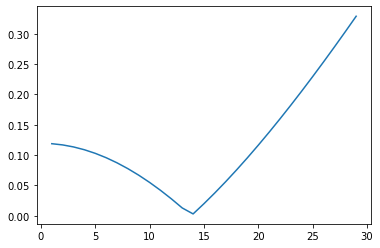

In [32]:
import matplotlib.pyplot as plt
plt.plot(weights,tops)


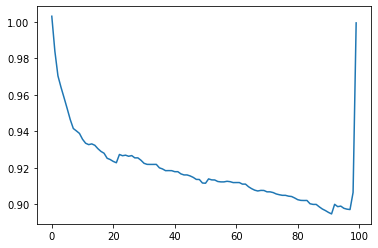

## MAE and MSE as function of SNR

In [9]:
def image_parameters_function(lower_limit_SNR, higher_limit_SNR, image_size = 256):
    from numpy.random import uniform, randint
    from numpy import ones
    from math import pi
    
    #particle_number = randint(1, 3)
    particle_number = 1
    particle_radius_list = uniform(1, 3, particle_number)
    (particle_center_x_list, particle_center_y_list) = IG.generate_particle_positions(particle_radius_list, image_size)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([1, ])
        particle_intensities_list.append([uniform(0.05, 0.13, 1), ])

    image_parameters = IG.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(.3, .5),
        signal_to_noise_ratio=lambda: uniform(lower_limit_SNR, higher_limit_SNR),
        gradient_intensity=lambda: uniform(0, 0),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters

Iteration: 0, SNR: 5
Time taken for iteration 0 : 21.232951164245605 sec


Iteration: 1, SNR: 10
Time taken for iteration 1 : 18.656657218933105 sec


Iteration: 2, SNR: 15
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
Time taken for iteration 2 : 24.546616792678833 sec


Iteration: 3, SNR: 20
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
par

particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no

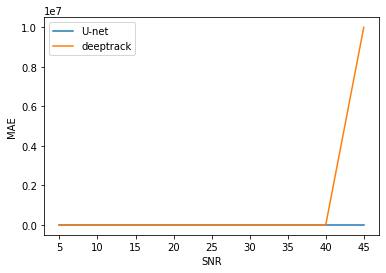

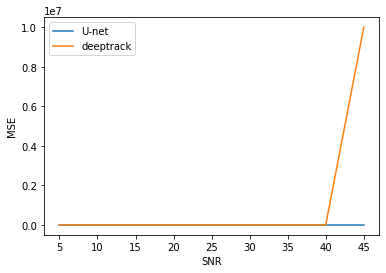

In [28]:
from numpy import zeros
import matplotlib.pyplot as plt
import os
import glob
import time

number_of_images_to_save = 50
model = unet.create_unet(pretrained_weights = "unet_particle.hdf5")

#particle_radial_distance_threshold = 10
#particle_maximum_interdistance = 5

particle_radial_distance_threshold = params[0]
particle_maximum_interdistance = params[1]

SNRs = range(5,50,5)
unet_MAE = zeros(len(SNRs))
unet_MSE = zeros(len(SNRs))
DT_MAE = zeros(len(SNRs))
DT_MSE = zeros(len(SNRs))

files = glob.glob('./images/*')
for f in files:
    os.remove(f)


verbose = True

for itt,lower_SNR in enumerate(SNRs,0):
    if(verbose):
        print("Iteration: {}, SNR: {}".format(itt, lower_SNR))
        t = time.time()
    
    get_image_parameters_function=lambda: image_parameters_function(lower_SNR,lower_SNR + 5,image_size = 51)

    batch_images,batch_labels,batch_predictions, particle_positions_and_radiuses = IG.get_batch(get_image_parameters_function = get_image_parameters_function,
                                                                                                batch_size=number_of_images_to_save,
                                                                                                include_particle_positions_radii_and_intensities = True,
                                                                                                verbose = False) 
    
    
    
    
        
    for image_number,image in enumerate(batch_images):
        if image_number>=number_of_images_to_save:
            break
        else:
            filepath = './images/frame{}.jpg'.format(str(image_number))
            image = image*255
            cv2.imwrite(filepath,image)

    cv2.destroyAllWindows()
    
    benchmark.construct_video_from_images()
    
    saved_network_file_name = "DeepTrack - Example 3 - Pretrained network.h5"
    dt_model = DT.load(saved_network_file_name)

    video = cv2.VideoCapture("output.mp4")
    (number_frames_to_be_tracked, frames, predicted_positions_wrt_frame, predicted_positions_wrt_box, 
        boxes_all) = DT.track_video("output.mp4",
                                    dt_model,box_half_size = 10,box_scanning_step = 2,
                                    frame_normalize = 0,frame_enhance = 1,
                                    number_frames_to_be_tracked = 0)
    
    

    predicted_positions_DT = benchmark.get_predicted_positions_DT(particle_radial_distance_threshold,
        particle_maximum_interdistance,
        number_frames_to_be_tracked,
        predicted_positions_wrt_frame)


    nr_real_particles,nr_predictions,nr_TP,nr_FP,TP,FP_DT,links_DT,MAE,MSE = benchmark.hits_and_misses(number_frames_to_be_tracked,
                                                                      predicted_positions_DT,
                                                                      particle_positions_and_radiuses,
                                                                      long_return = True)

    DT_MAE[itt] = MAE
    DT_MSE[itt] = MSE
    
    video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

    batch_images = np.zeros((number_frames_to_be_tracked,video_height,video_width,1))


    for i in range(number_frames_to_be_tracked):
        (ret, frame) = video.read()
        batch_images[i,:,:,0] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255

    
    batch_predictions_unet = unet.predict(model,batch_images)

    predicted_positions_unet = benchmark.get_predicted_positions_unet(number_frames_to_be_tracked,
                                                                      batch_predictions_unet,
                                                                      video_width,
                                                                      video_height)


    nr_real_particles,nr_predictions,nr_TP,nr_FP,TP,FP_unet,links_unet,MAE,MSE = benchmark.hits_and_misses(number_frames_to_be_tracked,
                                                                      predicted_positions_unet,
                                                                      particle_positions_and_radiuses,
                                                                      long_return = True)

    unet_MAE[itt] = MAE
    unet_MSE[itt] = MSE
    
    if(verbose):
        time_taken = time.time() - t
        print("Time taken for iteration {} : {} sec".format(itt,time_taken))
        print()
        print()

plt.plot(SNRs,unet_MAE,label = "U-net")
plt.plot(SNRs,DT_MAE, label = "deeptrack")
plt.legend(loc="upper left")
plt.xlabel("SNR")
plt.ylabel("MAE")
plt.show()

plt.plot(SNRs,unet_MSE,label = "U-net")
plt.plot(SNRs,DT_MSE, label = "deeptrack")
plt.legend(loc="upper left")
plt.xlabel("SNR")
plt.ylabel("MSE")
plt.show()

In [27]:
print("avg DT MAE: {}".format(np.mean(DT_MAE)))
print("avg DT MSE: {}".format(np.mean(DT_MSE)))
print("avg unet MAE: {}".format(np.mean(unet_MAE)))
print("avg unet MAE: {}".format(np.mean(DT_MSE)))

avg DT MAE: 1111112.3320353774
avg DT MSE: 1111113.462376783
avg unet MAE: 0.5929884276264802
avg unet MAE: 1111113.462376783


In [23]:
print("avg DT MAE: {}".format(np.mean(DT_MAE)))
print("avg DT MSE: {}".format(np.mean(DT_MSE)))
print("avg unet MAE: {}".format(np.mean(unet_MAE)))
print("avg unet MAE: {}".format(np.mean(DT_MSE)))

avg DT MAE: 7777777.2961843945
avg DT MSE: 7777777.4279290335
avg unet MAE: 0.469723214501544
avg unet MAE: 7777777.4279290335


In [ ]:
import matplotlib.pyplot as plt

params = params
diffs = range(-10,10,1)
distance = np.zeros(len(diffs))

verbose = False

for i,diff in enumerate(diffs,0):
    predicted_positions_DT = benchmark.get_predicted_positions_DT(params[0]+diff/10,
                                                                  params[1],
                                                                  number_frames_to_be_tracked,
                                                                  predicted_positions_wrt_frame,
                                                                  verbose = False)


    image_size_x = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    image_size_y = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    scanning_box_size_x = image_size_x / 12
    scanning_box_size_y = image_size_y / 12
    scanning_box_step_x = scanning_box_size_x / 100
    scanning_box_step_y = scanning_box_size_y / 100


    P, N, TP, FP, TN, FN = get_op_chars(predicted_positions_DT,
                                        particle_positions_and_radiuses,
                                        image_size_x, image_size_y,
                                        scanning_box_size_x, scanning_box_size_y,
                                        scanning_box_step_x, scanning_box_step_y)

    
    dist = benchmark.distance_from_upper_left_corner_ROC((P, N, TP, FP, TN, FN),100)
    distance[i] = dist
    
    if(verbose):print(dist)


plt.plot(diffs,distance,label = "distance")
plt.legend(loc="upper left")
plt.xlabel("deviation from optimal first parameter")
plt.ylabel("Distance from upper left corner in ROC-curve")
plt.show()




##now vary second parameter
diffs = range(-10,10,1)
distance = np.zeros(len(diffs))

verbose = False

for i,diff in enumerate(diffs,0):
    predicted_positions_DT = benchmark.get_predicted_positions_DT(params[0],
                                                                  params[1]+diff/10,
                                                                  number_frames_to_be_tracked,
                                                                  predicted_positions_wrt_frame,
                                                                  verbose = False)


    image_size_x = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    image_size_y = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    scanning_box_size_x = image_size_x / 12
    scanning_box_size_y = image_size_y / 12
    scanning_box_step_x = scanning_box_size_x / 100
    scanning_box_step_y = scanning_box_size_y / 100


    P, N, TP, FP, TN, FN = get_op_chars(predicted_positions_DT,
                                        particle_positions_and_radiuses,
                                        image_size_x, image_size_y,
                                        scanning_box_size_x, scanning_box_size_y,
                                        scanning_box_step_x, scanning_box_step_y)

    
    dist = benchmark.distance_from_upper_left_corner_ROC((P, N, TP, FP, TN, FN),100)
    distance[i] = dist
    
    if(verbose):print(dist)

plt.plot(diffs,distance,label = "distance")
plt.legend(loc="upper left")
plt.xlabel("deviation from optimal first parameter")
plt.ylabel("Distance from upper left corner in ROC-curve")
plt.show()